In [1]:
import numpy, pandas, glob, random, seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib import colors
import rpy2.robjects as R
from rpy2.robjects import numpy2ri, pandas2ri
numpy2ri.activate()
pandas2ri.activate()
from rich import progress
import sklearn.linear_model
import statsmodels
import statsmodels.api as sm
from statsmodels.stats import multitest
from pyplink import PyPlink
from utils import rsid2gene

In [2]:
# define cohort and taxonomy level
cohort = 'both'
taxa_level = 'genus'
bmi_or_not = 'bmi'
classification = 'silva'

In [3]:
# load pheno
micro_metab_adj = pandas.read_csv('../joint_pheno/{0}_{1}_{2}_micro_metab_adj.pheno'.format(cohort, taxa_level, classification), index_col = [0,1])
micro_metab_adj.index = micro_metab_adj.index.droplevel(0)

# load association
micro_metab_assoc = pandas.read_csv('../assoc_results/{0}_all_metabolite_all_{1}_{3}_assoc_fdr_corr_{2}.csv'.format(cohort, taxa_level, bmi_or_not, classification))
micro_metab_assoc['metabolite_id'] = micro_metab_assoc['metabolite_id'].astype(str)
sig_metabolite = micro_metab_assoc['metabolite_id'].unique()
print(len(sig_metabolite))

# get metadata
metabolite_metadata = pandas.read_csv('../input_pheno/no_micro_metab_10202019.pheno.metadata', sep = '\t', dtype=str)
metabolite_metadata = metabolite_metadata.groupby('metabolite_id').first()[['metabolite']]
taxa_metadata = pandas.read_csv('../joint_pheno/{0}_{1}.metadata'.format(taxa_level, classification + "_classification"), sep = '\t', dtype=str)
taxa_metadata = taxa_metadata.set_index('tax_id')

print(len(micro_metab_adj))

522
1163


# micro

In [4]:
lasso_micro_metab_coef = {}
lasso_micro_metab_stats = {}

for metab in progress.track(sig_metabolite, description="Fitting"):
    
    # get taxas associated with metabolite
    taxa = list(micro_metab_assoc.loc[micro_metab_assoc['metabolite_id'] == metab, 'tax_id'].values)

    # remove na's
    temp_micro_metab = micro_metab_adj[taxa + [metab]].dropna()

    # perform lasso regression
#     lasso_micro_metab = sklearn.linear_model.LassoCV(cv = 10, random_state = 574839, max_iter=1000)
    model = sm.OLS(temp_micro_metab[metab], sm.add_constant(temp_micro_metab[taxa])).fit()
    dims = temp_micro_metab.loc[:,taxa].shape
    r2 = model.rsquared

    # store coefficients
    lasso_micro_metab_coef[metab] = model.params[1:]
    lasso_micro_metab_stats[metab] = {'micro_r_squared': r2, 'micro_f_statistics': model.fvalue, 'micro_p_value': model.f_pvalue}


Output()

In [5]:
# convert results into long form, where [taxonomy_id, metabolite_id, and non-zero coefficient]
lasso_micro_metab_coef_df = pandas.DataFrame.from_dict(lasso_micro_metab_coef)
lasso_micro_metab_coef_df = lasso_micro_metab_coef_df[lasso_micro_metab_coef_df != 0]
lasso_micro_metab_coef_melt = lasso_micro_metab_coef_df.reset_index().melt(id_vars = 'index').dropna()
lasso_micro_metab_coef_melt.columns = ['tax_id','metabolite_id','coefficient']

# join with metadata
lasso_micro_metab_stats_df = pandas.DataFrame.from_dict(lasso_micro_metab_stats, orient = 'index').join(metabolite_metadata)

In [6]:
# get ONLY significant SNP associations
sig_metab_assoc = pandas.read_csv('../validate_gwas/clumped_variants/metab/fastgwa/clumped_10perc_second_pass_list.txt',
               sep = '\t', header = None)
sig_metab_assoc.columns = ['rsid', 'Phenotype']
# sig_metab_assoc = sig_metab_assoc[~sig_metab_assoc['Phenotype'].str.contains('X999')]
sig_metab_assoc = numpy.unique(sig_metab_assoc['Phenotype'].str.replace('X','').astype(str).values)
sig_metab_micro_lasso_coef_melt = lasso_micro_metab_coef_melt[lasso_micro_metab_coef_melt['metabolite_id'].isin(sig_metab_assoc)]
sig_metab_micro_lasso_coef_melt.to_csv('../assoc_results/{0}_sig_metab_{1}_{2}_classification_lasso.csv'.format(cohort, taxa_level, classification), index = None)


In [7]:
len(sig_metab_micro_lasso_coef_melt['metabolite_id'].unique())

176

In [8]:
genotype = PyPlink('../input_bed/all_chr/all_genomes_09112019_all_chr')
sample_ids = genotype.get_fam().iid.values

In [9]:
sig_metab_assoc = pandas.read_csv('../validate_gwas/clumped_variants/metab/fastgwa/clumped_10perc_second_pass_list.txt', sep = '\t', header = None)
sig_metab_assoc.columns = ['rsid', 'Phenotype']
sig_metab_assoc[~sig_metab_assoc['Phenotype'].str.contains('X999')]
sig_metab_assoc['Phenotype'] = sig_metab_assoc['Phenotype'].str.split('X').str.get(-1)

In [10]:
genes = rsid2gene(sig_metab_assoc.rsid.unique())
sig_metab_assoc = sig_metab_assoc.merge(genes, left_on="rsid", right_on="snp", how="left")
sig_metab_assoc = sig_metab_assoc.merge(metabolite_metadata, left_on="Phenotype", right_index=True, how="left")

In [11]:
len(sig_metab_assoc['Phenotype'].unique())

299

In [12]:
geno_metab_stats = {}

for metab in progress.track(sig_metab_assoc['Phenotype'].unique(), description="Fitting"):
    
    rsids = sig_metab_assoc[sig_metab_assoc['Phenotype'] == metab].rsid.unique()

    geno = pandas.DataFrame([])
    for rsid in rsids:
        temp = pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid])
        geno = geno.join(temp, how='outer')

    metab_geno = geno.join(micro_metab_adj[[metab]], how = 'inner').dropna()
    ols_model = sm.OLS(metab_geno[metab], sm.add_constant(metab_geno[rsids])).fit()
    r2 = ols_model.rsquared
    
    geno_exp_var = {'genetics_r_squared': r2, 'genetics_f_statistics': model.fvalue, 'genetics_p_value': model.f_pvalue}
    
    geno_metab_stats[metab] = geno_exp_var

Output()

In [13]:
geno_metab_stats_df = pandas.DataFrame.from_dict(geno_metab_stats, orient = 'index').join(metabolite_metadata)

# additive effect

In [14]:
from statsmodels.stats.multitest import fdrcorrection
import numpy as np

joint_r_sq = lasso_micro_metab_stats_df[['micro_r_squared', 'micro_p_value']].join(geno_metab_stats_df[['genetics_r_squared', 'genetics_p_value']], how = 'outer')
joint_r_sq[["micro_r_squared", "genetics_r_squared"]] = joint_r_sq[["micro_r_squared", "genetics_r_squared"]].fillna(0)
joint_r_sq[["micro_p_value", "genetics_p_value"]] = joint_r_sq[["micro_p_value", "genetics_p_value"]].fillna(1)
joint_r_sq['total'] = joint_r_sq['micro_r_squared'] + joint_r_sq['genetics_r_squared'] 
joint_r_sq['genetics_q'] = fdrcorrection(joint_r_sq.genetics_p_value)[1]
joint_r_sq['micro_q'] = fdrcorrection(joint_r_sq.micro_p_value)[1]
joint_r_sq['min_p'] = joint_r_sq[['micro_p_value', 'genetics_p_value']].min(1)
joint_r_sq = joint_r_sq.sort_values('total', ascending = False)
joint_r_sq.index.name = 'metabolite_id'
joint_r_sq = joint_r_sq.join(metabolite_metadata)
joint_r_sq = joint_r_sq[~joint_r_sq['metabolite'].str.contains('X -')]

joint_r_sq

,micro_r_squared,micro_p_value,genetics_r_squared,genetics_p_value,total,genetics_q,micro_q,min_p,metabolite
metabolite_id,,,,,,,,,
100001054,0.008811,1.786526e-03,0.506851,0.0006,0.515662,0.001295,2.387944e-03,6.004280e-04,butyrylcarnitine (C4)
100020550,0.049031,2.986772e-06,0.437716,0.0006,0.486746,0.001295,1.133989e-05,2.986772e-06,deoxycholic acid glucuronide
100001577,0.000000,1.000000e+00,0.455079,0.0006,0.455079,0.001295,1.000000e+00,6.004280e-04,N-acetylcitrulline
100002253,0.428388,1.647778e-67,0.000000,1.0000,0.428388,1.000000,1.062817e-64,1.647778e-67,cinnamoylglycine
100004523,0.082892,3.935399e-10,0.316814,0.0006,0.399706,0.001295,3.845958e-09,3.935399e-10,N-delta-acetylornithine
...,...,...,...,...,...,...,...,...,...
100009035,0.008287,2.261272e-03,0.000000,1.0000,0.008287,1.000000,2.871103e-03,2.261272e-03,1-pentadecanoyl-2-linoleoyl-GPC (15:0/18:2)*
212,0.008226,2.547227e-03,0.000000,1.0000,0.008226,1.000000,3.177875e-03,2.547227e-03,5-methylthioadenosine (MTA)
100009181,0.008190,2.477472e-03,0.000000,1.0000,0.008190,1.000000,3.112368e-03,2.477472e-03,1-stearoyl-2-oleoyl-GPI (18:0/18:1)*


In [15]:
import pandas as pd

joint_r_sq["group"] = "hybrid"
joint_r_sq.loc[(joint_r_sq['micro_r_squared'] <= 0.01 * joint_r_sq['total']), "group"] = "genetics"
joint_r_sq.loc[(joint_r_sq['genetics_r_squared'] <= 0.01 * joint_r_sq['total']), "group"] = "microbiome"
joint_r_sq.sort_values(by="total", ascending=True, inplace=True)
joint_r_sq["metabolite"] = pd.Categorical(joint_r_sq.metabolite, joint_r_sq.metabolite.unique())
joint_r_sq.sort_values(by="total", ascending=False, inplace=True)

top = []
for g in ["genetics", "microbiome", "hybrid"]:
    top.extend(joint_r_sq[joint_r_sq.group == g].iloc[0:10].metabolite)
joint_r_sq.to_csv("joint_r_squared.csv", index=False)
long = joint_r_sq[["metabolite", "group", "micro_r_squared", "genetics_r_squared"]].melt(id_vars=["metabolite", "group"], value_name="r2", var_name = "type")

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/r2.pdf


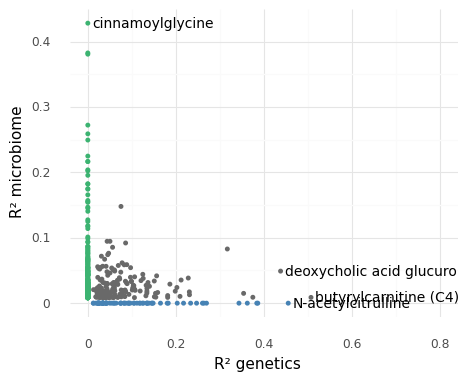

<ggplot: (8784277489761)>

In [16]:
from plotnine import *
from mizani.formatters import percent_format

pl = (
    ggplot(joint_r_sq[(joint_r_sq.genetics_r_squared >= 0) & (joint_r_sq.micro_r_squared >= 0)], aes(x="genetics_r_squared", y="micro_r_squared", color="group"))
    + geom_point(size=2, stroke=0)
    + geom_text(aes(label="metabolite"), data=joint_r_sq[joint_r_sq.total > 0.4], ha="left", nudge_x=0.01, size=10, color="black")
    + theme_minimal()
    + theme(figure_size=(5,4))
    + xlim(0, 0.8)
    + scale_color_manual(values={"genetics": "steelblue", "microbiome": "mediumseagreen", "hybrid": "dimgray"})
    + labs(x="R² genetics", y="R² microbiome") + guides(color=None)
)
pl.save("../figures/r2.pdf", width=6, height=4)
pl

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 6 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/specific_r2.pdf


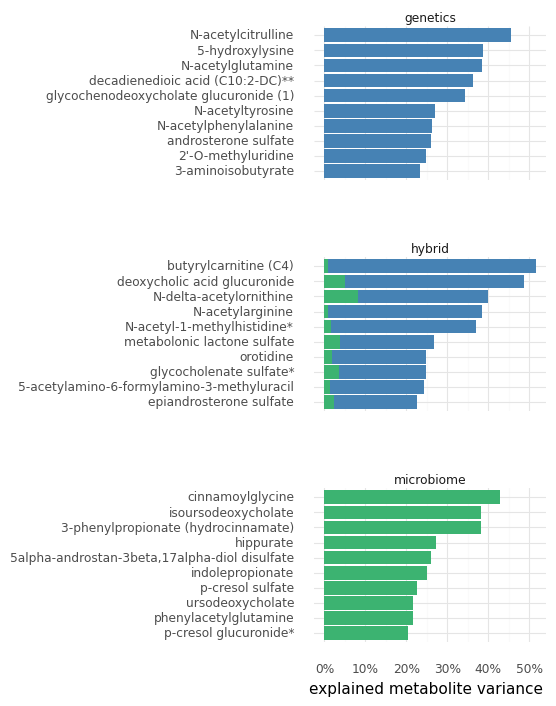

<ggplot: (8784295861887)>

In [17]:
pl = (
    ggplot(long[(long.r2 > 0.0) & (long.metabolite.isin(top))].sort_values(by="r2"), aes(y="r2", x="metabolite", fill="type"))
    + geom_bar(stat="identity") 
    + scale_y_continuous(labels=percent_format())
    + coord_flip()
    + facet_wrap("~ group", scales="free_y", ncol=1)
    + labs(y = "explained metabolite variance", x="")
    + scale_fill_manual(values=["steelblue", "mediumseagreen"])
    + guides(fill = None)
    + theme_minimal() 
    + theme(figure_size=(3, 8), subplots_adjust={"hspace": 0.5})
)
pl.save("../figures/specific_r2.pdf", width=3, height=6)
pl

In [18]:
joint_r_sq[joint_r_sq.group == "hybrid"].apply(lambda df: df.micro_r_squared/df.genetics_r_squared, axis=1).describe()

count    176.000000
mean       0.533836
std        0.507522
min        0.017383
25%        0.203847
50%        0.356383
75%        0.656963
max        2.488102
dtype: float64

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3.5 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/secondary_bas_r2.pdf
/proj/gibbons/gene_environment_interaction/gxe/explained_variance/utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

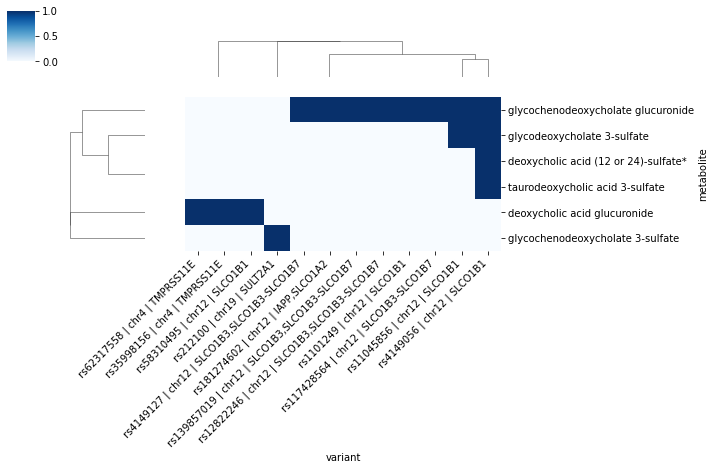

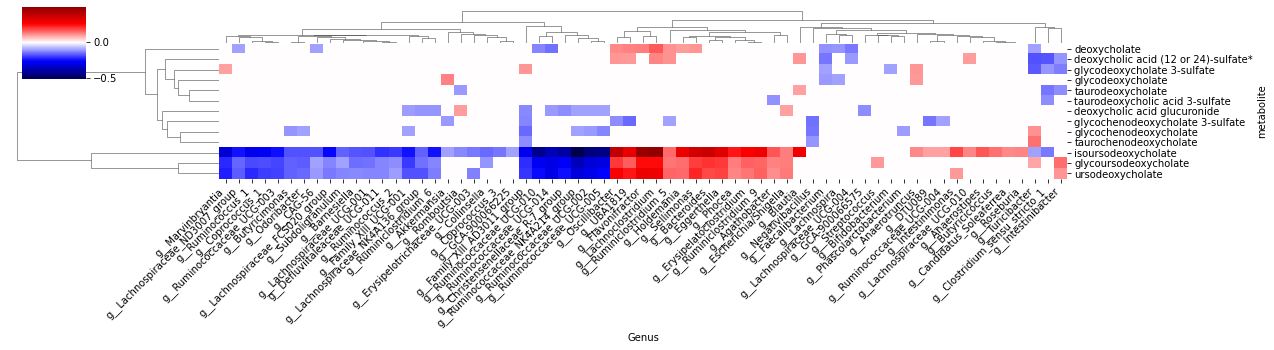

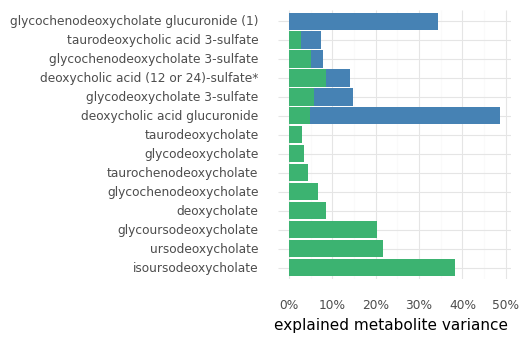

(<ggplot: (8784624807780)>,
 <seaborn.matrix.ClusterGrid at 0x7fd40d24f130>)

In [19]:
from utils import summarize_associations

deoxy = long[long.metabolite.str.contains("deoxychol", regex=True) & (long.r2 > 0.0001)].sort_values(["group", "r2"])
summarize_associations(deoxy, "secondary_bas", joint_r_sq, sig_metab_assoc, micro_metab_assoc)

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3.75 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/sphingolipids_r2.pdf
/proj/gibbons/gene_environment_interaction/gxe/explained_variance/utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

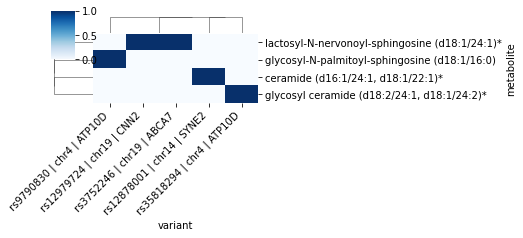

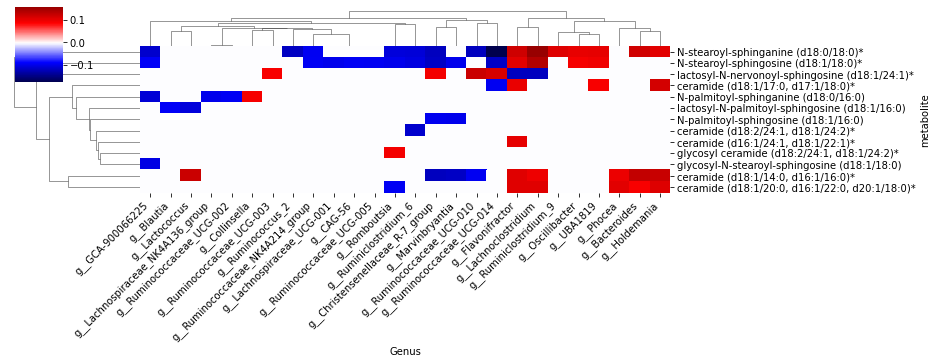

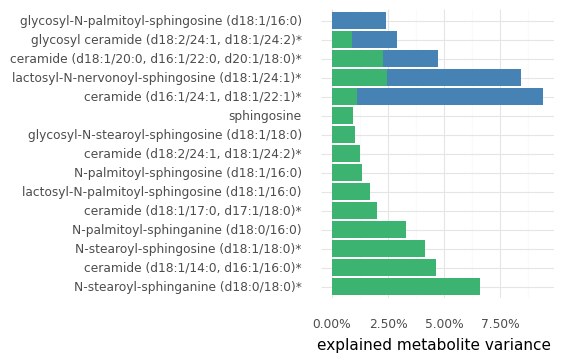

(<ggplot: (8784295782922)>,
 <seaborn.matrix.ClusterGrid at 0x7fd3fbd2d9a0>)

In [20]:
sphingo = long[long.metabolite.str.contains("sphingosine|ceram|sphinganine", regex=True) & (long.r2 > 0.0001)].sort_values(["group", "r2"])
summarize_associations(sphingo, "sphingolipids", joint_r_sq, sig_metab_assoc, micro_metab_assoc)

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/type_fractions.pdf


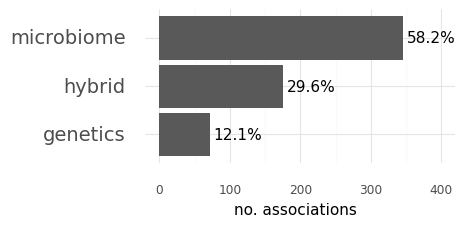

<ggplot: (8784295411914)>

In [21]:
pl = (
    ggplot(joint_r_sq, aes(x="group"))
    + geom_bar() 
    + theme_minimal()
    + theme(figure_size=(4, 2), axis_text_y = element_text(size=14))
    + ylim(0, 400)
    + labs(x="", y="no. associations")
    + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_y=5.0,
     va='center',
     ha="left",
     format_string='{:.1f}%'
     )
    + coord_flip()
  
)
pl.save("../figures/type_fractions.pdf", width=4, height=2)
pl

# joint model

In [22]:
micro_genetic_effects = joint_r_sq[(joint_r_sq['genetics_r_squared'] != 0) & (joint_r_sq['micro_r_squared'] != 0)]

In [23]:
joint_model_stats = {}
features = taxa # lasso_micro_metab_coef_melt.loc[lasso_micro_metab_coef_melt['metabolite_id'].isin(metabolites_w_micro_genetics.index), 'tax_id'].unique()

for metab in progress.track(joint_r_sq[joint_r_sq.group=="hybrid"].index, description="Fitting"):
    # temp_features = lasso_micro_metab_coef_melt.loc[lasso_micro_metab_coef_melt['metabolite_id'] == metab, 'tax_id'].values
    taxa = list(micro_metab_assoc.loc[micro_metab_assoc['metabolite_id'] == metab, 'tax_id'].values)
    temp_pheno = micro_metab_adj[list(taxa) + [metab]]
    
    rsids = sig_metab_assoc[sig_metab_assoc['Phenotype'] == metab].rsid.unique()

    geno = pandas.DataFrame([])
    for rsid in rsids:
        temp = pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid])
        geno = geno.join(temp, how='outer')
    
    joint_geno_env_pheno = geno.join(temp_pheno, how = 'inner').dropna()
    
    model_micro = sm.OLS(joint_geno_env_pheno[metab], sm.add_constant(joint_geno_env_pheno[list(taxa)])).fit()
    model_genetics = sm.OLS(joint_geno_env_pheno[metab], sm.add_constant(joint_geno_env_pheno[list(rsids)])).fit()
    model_both = sm.OLS(joint_geno_env_pheno[metab], sm.add_constant(joint_geno_env_pheno[list(taxa) + list(rsids)])).fit()
    dims = joint_geno_env_pheno[list(taxa) + list(rsids)].shape
    
    joint_model_stats[metab] = {
        'micro_r_squared': model_micro.rsquared,
        'genetics_r_squared': model_genetics.rsquared,
        'joint_r_squared': model_both.rsquared, 
        'joint_f_statistics': model_both.fvalue,
        'joint_p_value': model_both.f_pvalue,
        'joint_n': dims[0]
    }
    

Output()

In [24]:
joint_comparison = pandas.DataFrame.from_dict(joint_model_stats, orient = 'index').join(joint_r_sq[["metabolite"]]).sort_values('joint_r_squared', ascending = False)
joint_comparison["total"] = joint_comparison[["micro_r_squared", "genetics_r_squared"]].sum(1)
joint_comparison.index.name == 'metabolite_id'
joint_comparison = joint_comparison.reset_index()
joint_comparison['additive_tick_loc'] = joint_comparison.index.values*2 + 0.375
joint_comparison['joint_tick_loc'] = joint_comparison.index.values*2 + 1.125
joint_comparison['lable_tick_loc'] = joint_comparison.index.values*2 + 0.75

<ipython-input-25-ebbc36acb295>:17: UserWarning: FixedFormatter should only be used together with FixedLocator


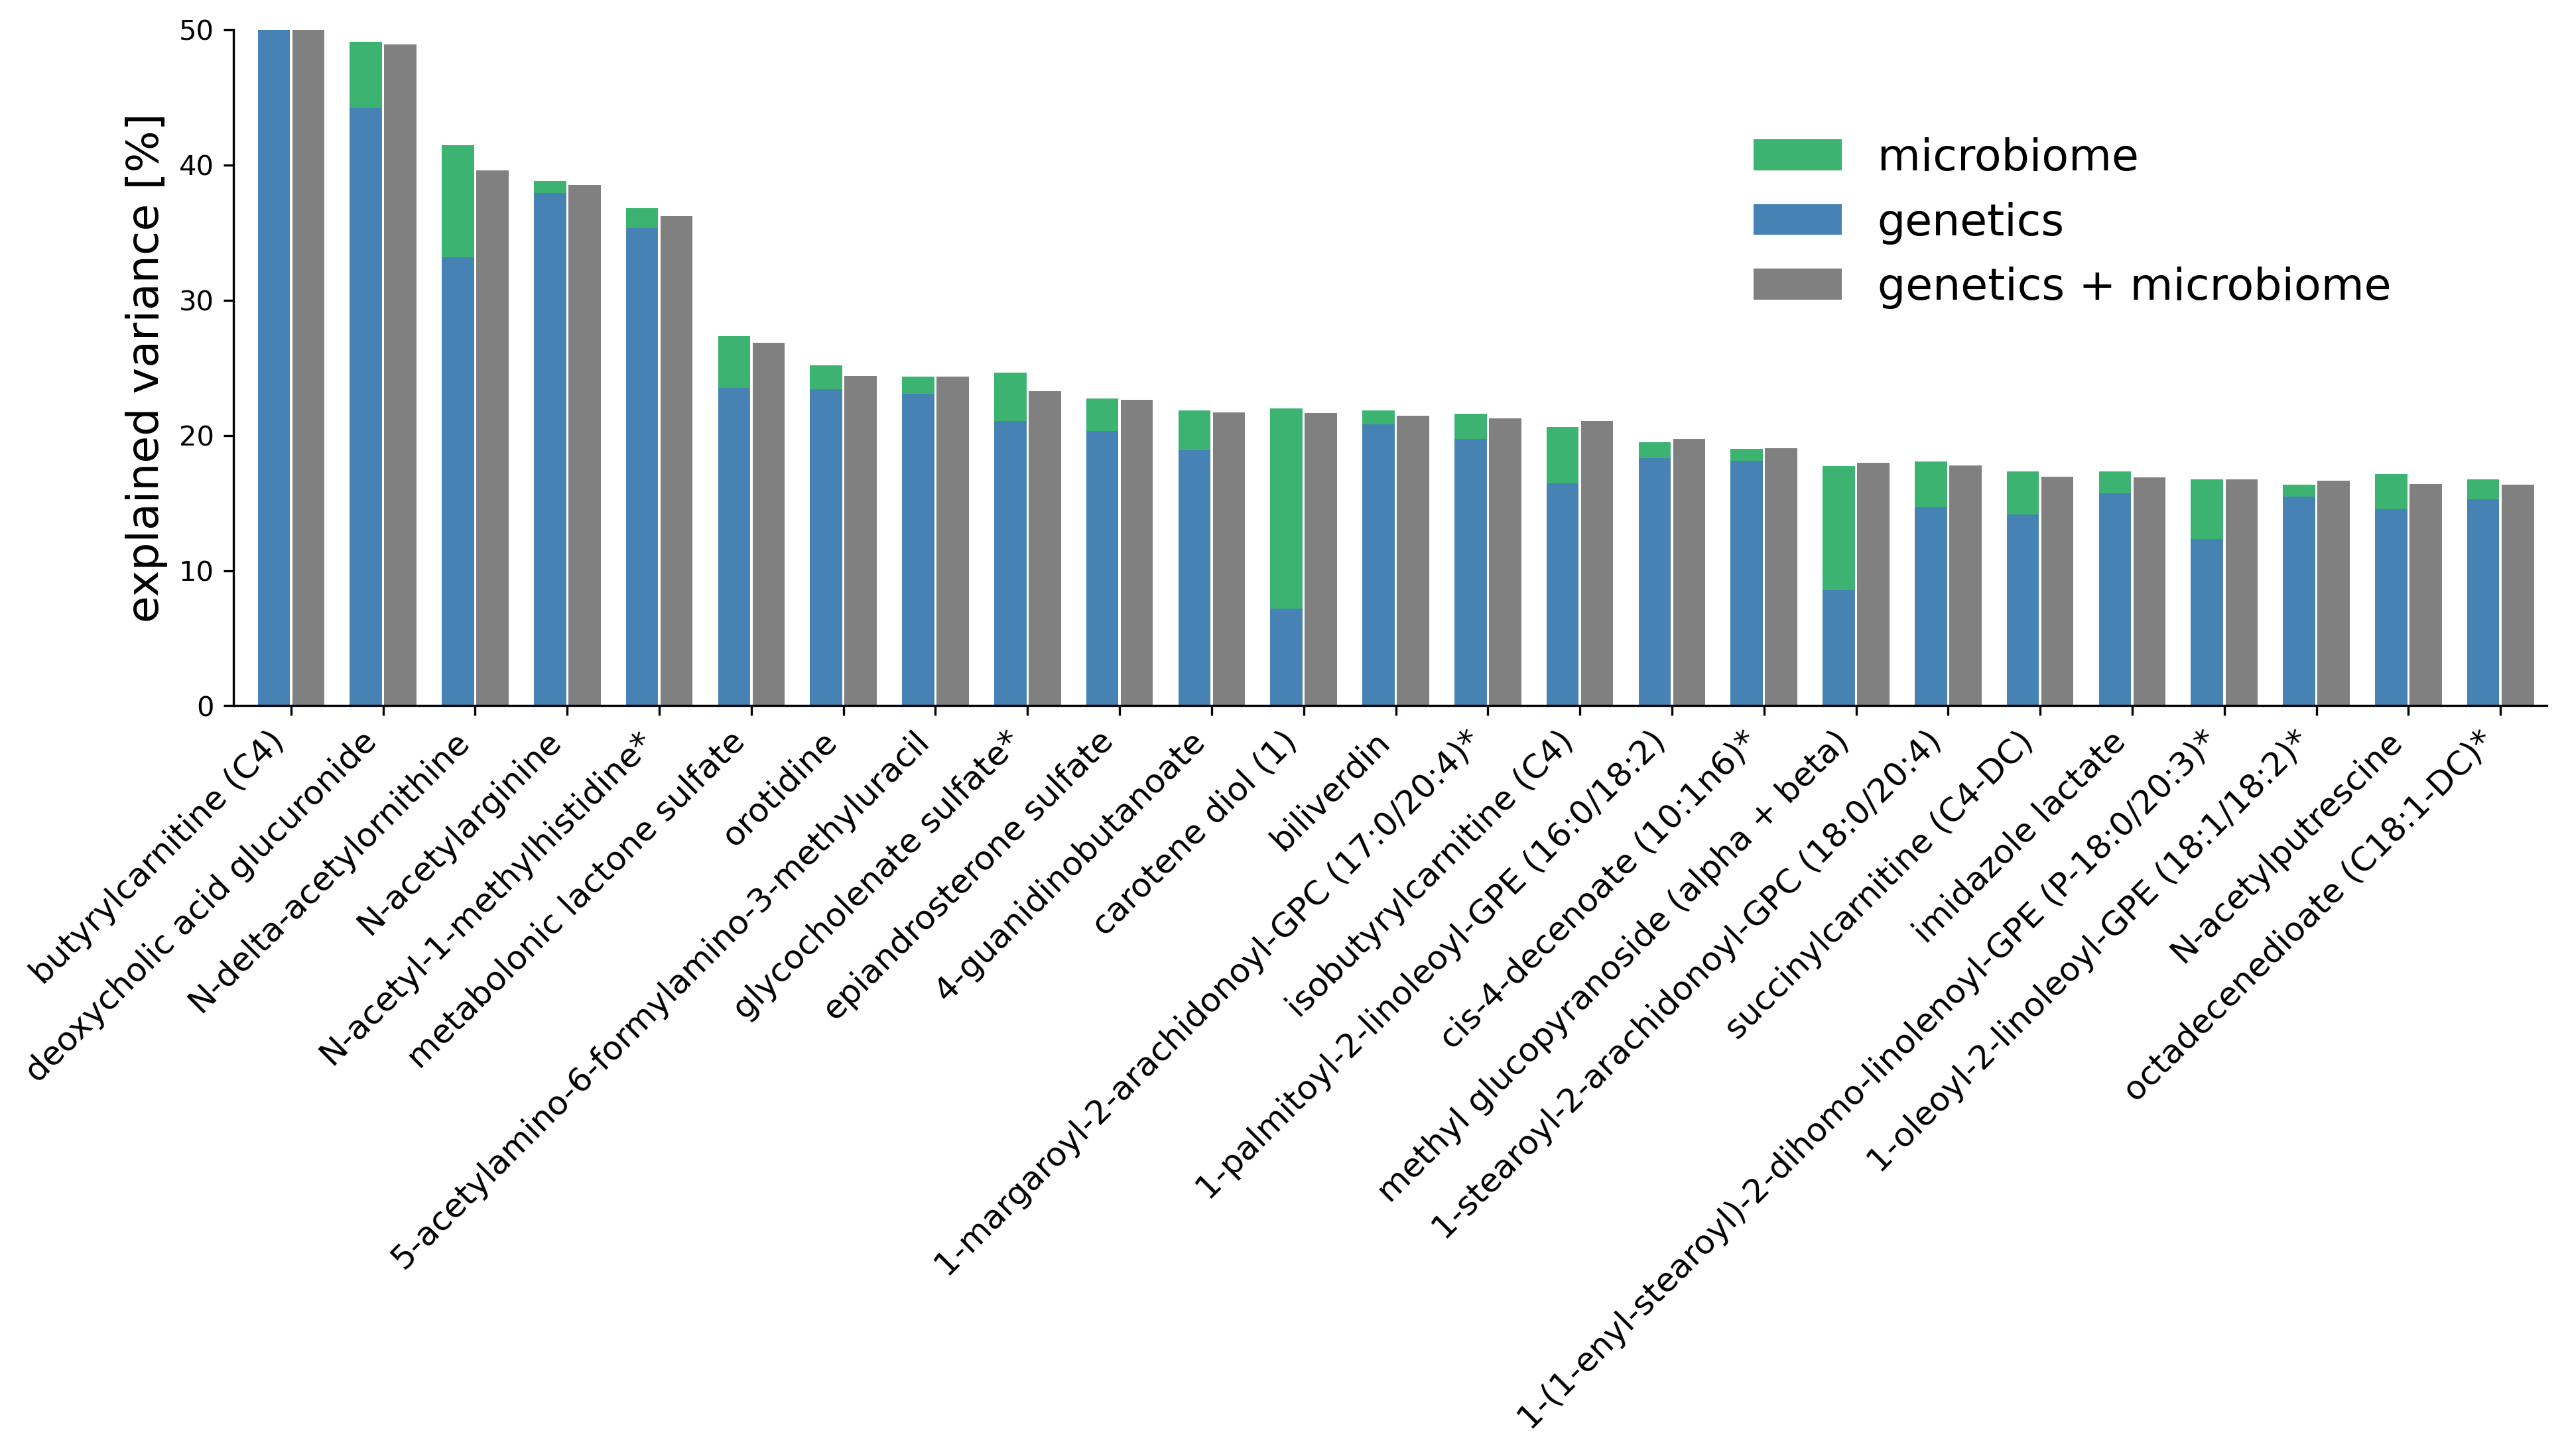

In [25]:
cutoff = 25
range_max = int(numpy.round(joint_comparison['joint_r_squared'].max(), 1) * 100)

joint_subset = joint_comparison.iloc[:cutoff,:]

fig = plt.figure(figsize=(15, 4.5), dpi = 300)
ax = plt.subplot()
ax.bar(joint_subset["additive_tick_loc"], joint_subset["total"], width=0.7,
            label="microbiome", color="mediumseagreen")
ax.bar(joint_subset["additive_tick_loc"], joint_subset["genetics_r_squared"],width=0.7,
            label="genetics", color="steelblue")
ax.bar(joint_subset["joint_tick_loc"], joint_subset["joint_r_squared"],width=0.7,
            label="genetics + microbiome", color="grey")
sns.despine()
ax.set_ylim([0,range_max/100])
ax.set_xlim([-0.5,max(joint_subset['lable_tick_loc'].values) + 1])
ax.set_yticklabels(list(range(0,range_max + 10,10)), fontdict={'size':10})
ax.set_xticks((joint_subset['lable_tick_loc'].values))
ax.set_xticklabels(joint_subset['metabolite'], fontdict={'size':12}, rotation = 45, ha = 'right')
ax.set_ylabel('explained variance [%]', fontdict={'size':16})
ax.set_xlabel('')
ax.legend(bbox_to_anchor = (0.95, 0.9), frameon=False, prop={'size': 16})
plt.savefig("../figures/hybrid_r2.pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()
plt.close()

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.5 x 4 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/r2_overlap.pdf


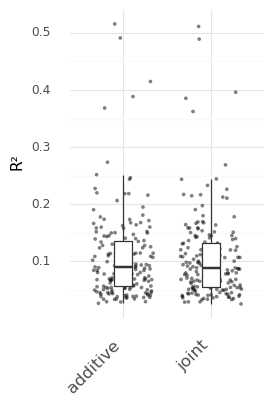

<ggplot: (8784276862474)>

In [26]:
model_comp = joint_comparison[["metabolite", "total", "joint_r_squared"]].rename(columns={"total": "additive", "joint_r_squared": "joint"}).melt(id_vars="metabolite", var_name="type", value_name="r2")
pl = (
    ggplot(model_comp, aes(x="type", y="r2"))
    + geom_jitter(height=0, width=0.35, alpha=0.5, stroke=0)
    + geom_boxplot(width=0.2, outlier_color="none")
    + theme_minimal()
    + labs(x="", y="R²")
    + theme(figure_size=(2.5, 4), axis_text_x = element_text(angle=45, ha="right", va="top", size=12))
)
pl.save("../figures/r2_overlap.pdf", width=2.5, height=4)
pl

In [27]:
from scipy.stats import wilcoxon

print((joint_comparison.total - joint_comparison.joint_r_squared).describe())
wilcoxon(joint_comparison.total, joint_comparison.joint_r_squared)

count    176.000000
mean       0.001650
std        0.003023
min       -0.005701
25%        0.000005
50%        0.001258
75%        0.002978
max        0.018751
dtype: float64


WilcoxonResult(statistic=2976.0, pvalue=1.1699206217406068e-12)

In [28]:
micro_metab_adj.shape

(1163, 1024)

In [29]:
micro_metab_adj.loc[:, micro_metab_adj.columns.str.contains("_genus")].shape

(1163, 78)